#<font color=blue>**SSD 객체 인식 실습**</font>
각 셀을 순서대로 shift + ENTER로 실행

##<font color=green>**구글 드라이브 연결**</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##<font color=green>**SSD를 적용하기위한 적절한 라이브러리 설치 진행**
####<font color=red>런타임 초기화시 재설치 진행</font>

In [ ]:
!pip install tensorboard==1.15.0 tensorflow==1.15.0 tensorflow-estimator==1.15.1 tensorflow-gpu==1.15.2 tensorflow-gpu-estimator==2.1.0 Keras==2.2.5 Keras-Applications==1.0.8 Keras-Preprocessing==1.1.0

     |████████████████████████████████| 3.8MB 8.3MB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 52.1MB/s 
     |████████████████████████████████| 411.0MB 46kB/s 
     |████████████████████████████████| 471kB 56.8MB/s 
     |████████████████████████████████| 337kB 50.1MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=71ac160c285a8d70dbdb8f5c68fff7cfa4f96fb64832dc9aa76944dfdcc52296
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation:

##<font color=green>**구글 드라이브로 경로 이동**

In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


##<font color=green>**git의 SSD 설치**

In [ ]:
!git clone https://github.com/balancap/SSD-Tensorflow.git

fatal: destination path 'SSD-Tensorflow' already exists and is not an empty directory.


##<font color=green>**vgg 모델 설치**</font>

In [ ]:
%cd SSD-Tensorflow/checkpoints/
!unzip ssd_300_vgg.ckpt.zip

/content/drive/MyDrive/SSD-Tensorflow/checkpoints
Archive:  ssd_300_vgg.ckpt.zip
replace ssd_300_vgg.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ssd_300_vgg.ckpt.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


##<font color=green>**실습 폴더 경로로 이동**</font>

In [ ]:
cd ../notebooks/

/content/drive/MyDrive/SSD-Tensorflow/notebooks


##<font color=green>**SSD 실습 코드**</font>

####<font color=red>라이브러리 설정</font>

In [ ]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../')

from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



####<font color=red>학습된 모델 및 설정 적용</font>

In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


####<font color=red>이미지 SSD 적용 함수 구성</font>

In [ ]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

####<font color=red>이미지 데이터에 SSD 적용 실습 진행</font>
경로를 지정한 이미지에 SSD 적용
img = mpimg.imread('적용하고자하는이미지 경로')



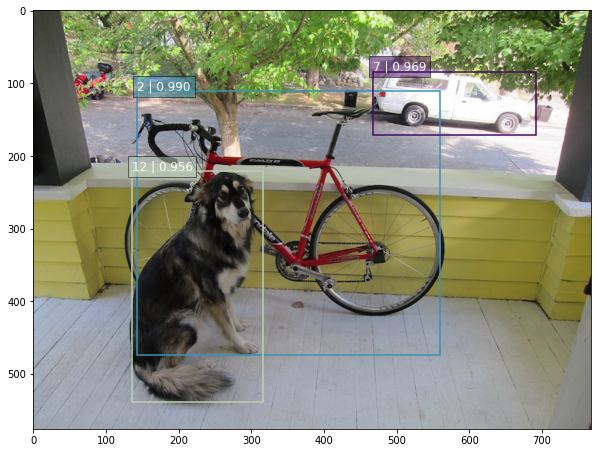

In [ ]:
# Test on some demo image and visualize output.

img = mpimg.imread('/content/drive/MyDrive/SSD-Tensorflow/demo/dog.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

##<font color=green>**데이터 업로드 진행**

####<font color=red>KITTI_data.mp4 다운로드</font>

In [ ]:
!gdown --id 1V68xfo5-YrpHgh0IPuAPWD21rM6U17hW --output KITTI_data.mp4

Downloading...
From: https://drive.google.com/uc?id=1_MLsDHKmoPSLBe3WuN1jrLWAvQoaOvQ2
To: /content/drive/My Drive/darknet/BDD_data.zip
346MB [00:04, 81.7MB/s]


##<font color=green>**SSD 영상 실습**</font>

####<font color=red>라이브러리 설정</font>

In [ ]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2
import time
slim = tf.contrib.slim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.append('../')
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

####<font color = red>적용하고자하는 영상 데이터 지정</font>

capture = cv2.VideoCapture('적용하고자하는 비디오데이터')

In [ ]:
capture = cv2.VideoCapture('KITTI_data.mp4')
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)

####<font color=red>학습 모델 및 설정 적용

In [ ]:
gpu_options = tf.GPUOptions(allow_growth=False)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
net_shape = (
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)
ssd_anchors = ssd_net.anchors(net_shape)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


####<font color=red>이미지 SSD 적용 함수 구성</font>
이미지에 SSD 적용 시의 클래스, 정확도, 경계박스 정보 도출

In [ ]:
def process_image(img, select_threshold=0.45, nms_threshold=.45, net_shape=net_shape):
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img], feed_dict={img_input: img})
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select( rpredictions, rlocalisations, ssd_anchors, select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

####<font color=red>영상 데이터에 SSD 적용 함수 구성</font>

In [ ]:
def video_bboxes(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!
    """
    cnames=['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            tl=(xmin,ymin)
            br=(xmax,ymax)
            img=cv2.rectangle(img,tl,br,colors[cls_id],2)
            class_name=cnames[cls_id]
       
            if cls_id<len(cnames):
                img=cv2.putText(img,'%s'%cnames[cls_id]+str(score),tl,cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
            #cv2_imshow(img)
    return img

####<font color=red>업로드된 영상데이터에 SSD 객체 인식 적용</font>

적용된 영상은 video_masked.avi로 저장

In [ ]:
codec = cv2.VideoWriter_fourcc(*'DIVX')
output = cv2.VideoWriter('video_masked.avi', codec, 30.0, size)

while (capture.isOpened()):
    ret, img = capture.read() # ret is true or false (if video is playing then its true)
    
    if ret:
      rclasses, rscores, rbboxes = process_image(img)
      frame = video_bboxes(img, rclasses, rscores, rbboxes)
      output.write(frame)
    else:
      break

capture.release()
output.release()
cv2.destroyAllWindows()

####<font color=red>Mask R-CNN 적용된 KITTI_data 다운로드</font>

In [ ]:
from google.colab import files
files.download('video_masked.avi')